In [1]:
!mkdir -p ./kaggle

In [2]:
!cp kaggle.json /kaggle/

In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:02<00:00, 28.3MB/s]
100% 60.3M/60.3M [00:02<00:00, 25.7MB/s]


In [4]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import tensorflow as tf
from PIL import Image


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [4]:
os.makedirs('test_dir',exist_ok=True)

In [41]:
#defining project name
project_name = "FER_2013_Emotion_Dection"

#list the models
models = [
    'Custom_CNN_from_Scratch',
    'Custom_CNN_from_Augmentation',
    'VGGnet16_Transfer_learning',
    'Resnet50_Transfer_learning'
]

In [6]:
#base directory
base_dir = '/content/'

#create project directory
project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)


#creating subdirectories for each model
for each_model in models:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)


## Data Cleaning

In [7]:
#defining acceptable image extensions
image_etxns = ['jpeg','jpg','png']

# data directory path
data_dir = '/content/train'

#walking through each directorys n files
for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)

    try:
      #checking the type of files
      file_type = imghdr.what(file_path)

      if file_type not in image_etxns:
        print(file_path," does not exist in extn list")
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e:
      print("Issue with ",file_path, "is ",e)
      os.remove(file_path)

In [8]:
def count_file_in_subdirs(directory,name):
  counts={}

  #iterating over items
  for item in os.listdir(directory):
    #constructing full item path
    item_path = os.path.join(directory,item)

    #checking whether the item exists in directory or not
    if os.path.isdir(item_path):
      #counts the no of files in subdirectory and adds in directory
      counts[item] = len(os.listdir(item_path))

  df  = pd.DataFrame(counts,index=[name])
  return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_file_in_subdirs(train_dir,'train')
test_count = count_file_in_subdirs(test_dir,'test')
print(train_count)
test_count

       disgust  fear  surprise  angry   sad  happy  neutral
train      436  4097      3171   3995  4830   7215     4965


,disgust,fear,surprise,angry,sad,happy,neutral
test,111,1024,831,958,1247,1774,1233


In [9]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
  #retrival of list of the file names from the directory
  image_file_names= os.listdir(directory_path)

  #if there are fewer images than requested, shown them all
  if len(image_file_names) < num_images:
    print("There are only", len(image_file_names)," displaying them all")
    num_images = len(image_file_names)

  #randomly selecting 'num_images'
  selected_images = random.sample(image_file_names,num_images)

  #plotting the images
  fig,axes = plt.subplots(nrows=3, ncols=3,figsize=(5,5)) #adjust as you need

  axes=axes.ravel()

  for i,image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)

    images=image.load_img(image_path)
    axes[i].imshow(images)
    axes[i].set_title(class_name)
    axes[i].axis('off')

  plt.show()


In [10]:
from keras.preprocessing import image

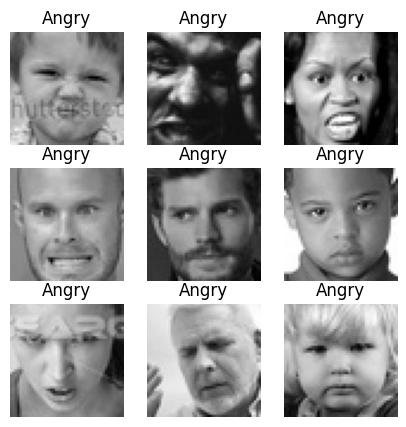

In [11]:

angry_dir_path='/content/train/angry'

plot_images_from_directory(angry_dir_path,"Angry")

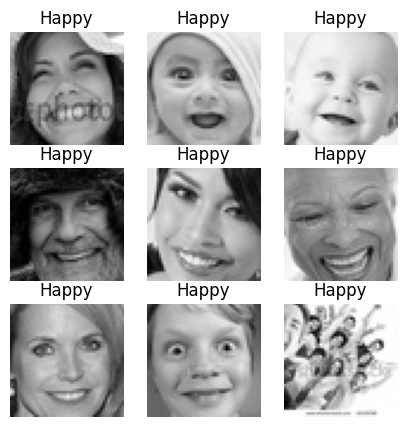

In [12]:

angry_dir_path='/content/train/happy'

plot_images_from_directory(angry_dir_path,"Happy")

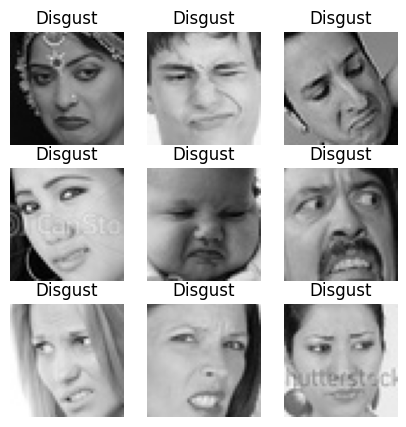

In [13]:

angry_dir_path='/content/train/disgust'

plot_images_from_directory(angry_dir_path,"Disgust")

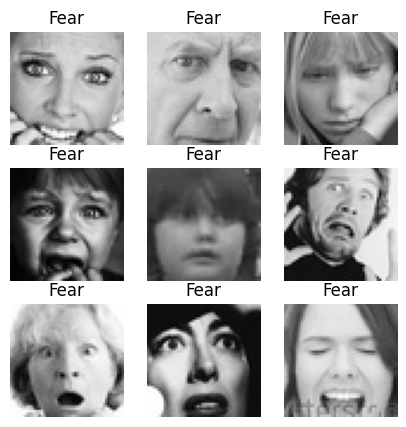

In [14]:

angry_dir_path='/content/train/fear'

plot_images_from_directory(angry_dir_path,"Fear")

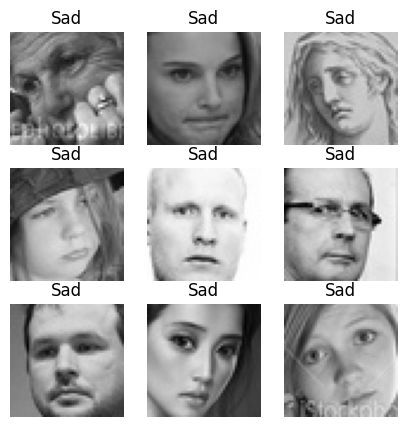

In [15]:

angry_dir_path='/content/train/sad'

plot_images_from_directory(angry_dir_path,"Sad")

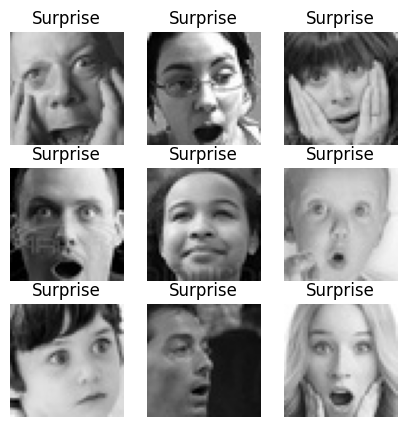

In [16]:

angry_dir_path='/content/train/surprise'

plot_images_from_directory(angry_dir_path,"Surprise")

Checking shapes and channels

In [17]:
image = '/content/train/angry/Training_10118481.jpg'

array([[[ 50,  50,  50],
        [ 32,  32,  32],
        [ 15,  15,  15],
        ...,
        [133, 133, 133],
        [151, 151, 151],
        [ 86,  86,  86]],

       [[ 57,  57,  57],
        [ 34,  34,  34],
        [ 22,  22,  22],
        ...,
        [138, 138, 138],
        [151, 151, 151],
        [ 89,  89,  89]],

       [[ 61,  61,  61],
        [ 30,  30,  30],
        [ 24,  24,  24],
        ...,
        [142, 142, 142],
        [149, 149, 149],
        [ 89,  89,  89]],

       ...,

       [[103, 103, 103],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [149, 149, 149],
        [104, 104, 104],
        [ 85,  85,  85]],

       [[107, 107, 107],
        [111, 111, 111],
        [113, 113, 113],
        ...,
        [151, 151, 151],
        [120, 120, 120],
        [ 86,  86,  86]],

       [[104, 104, 104],
        [104, 104, 104],
        [112, 112, 112],
        ...,
        [143, 143, 143],
        [136, 136, 136],
        [ 83,  83,  83]]], dtype=uint8)
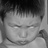

In [18]:
img = cv2.imread(image)
img

array([[ 50,  32,  15, ..., 133, 151,  86],
       [ 57,  34,  22, ..., 138, 151,  89],
       [ 61,  30,  24, ..., 142, 149,  89],
       ...,
       [103, 100, 100, ..., 149, 104,  85],
       [107, 111, 113, ..., 151, 120,  86],
       [104, 104, 112, ..., 143, 136,  83]], dtype=uint8)
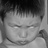

In [19]:
img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
img

## Model 1: Custom CNN from Scratch

Initializing the image Generators

In [20]:
# defining path for directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [21]:
img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [22]:
data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# automactically retrival of images from their classes for training and validation
train_generator = data_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')
    # subset='training')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# accessing class labels for the training data
train_class_labels = train_generator.class_indices
print(train_class_labels)

# accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print(validation_class_labels)

# accessing class labels for the test data
test_class_labels = test_generator.class_indices
print(test_class_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [24]:
# Initializing CNN

model=Sequential()

#convolutional layer
model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform', padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(1024,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

#DNN

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 1024)        │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      37,749,7

 Total params: 44,049,927 (168.04 MB)

 Trainable params: 44,047,239 (168.03 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

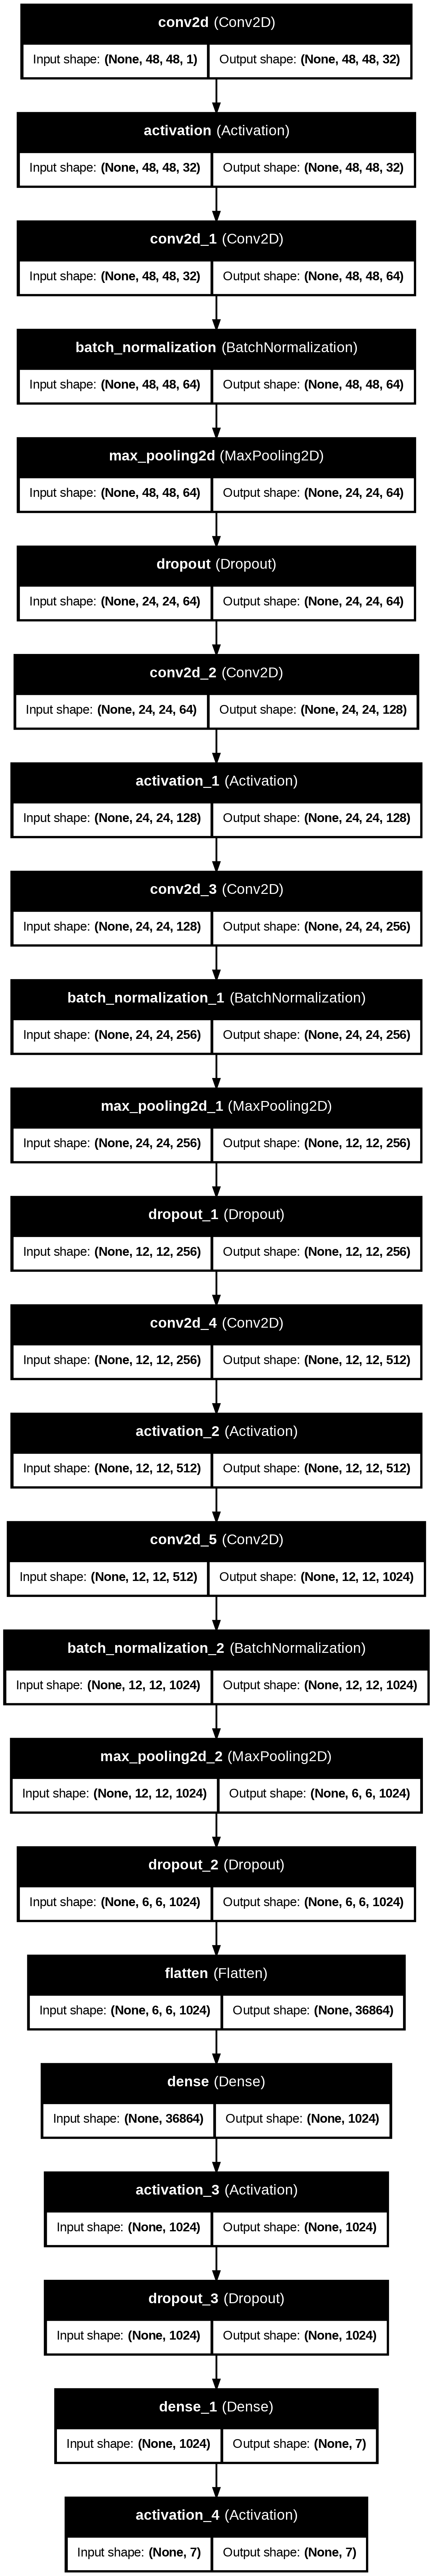

In [30]:
plot_model(model,to_file='/content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Architecure.png',show_shapes =True, show_layer_names= True)

## understanding call backs

In [31]:
# file path for model checkpoint

cnn_path = '/content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch'
name = 'Custom_CNN_From_Scratch.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras'

In [41]:
#callback to  save model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [42]:
#callback for early stopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=7,
                           verbose=1,
                           restore_best_weights=True)

In [43]:
# Reduce LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=7,
                              verbose=1,
                              min_delta=0.0001)

In [44]:
# CSV LOgger -> to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training_log.csv'))

In [45]:
# aggregating all callback

Callbacks = [checkpoint,early_stop,reduce_lr,csv_logger]

## Calculating  steps for epoch

In [46]:
train_generator.samples

22968

In [47]:
# train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size + 1
# test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1

import math

train_steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
# validation_steps_per_epoch = math.ceil(validation_generator.samples / validation_generator.batch_size) #old
validation_steps_per_epoch = math.ceil(len(validation_generator) / validation_generator.batch_size)

test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)


In [48]:
train_generator.batch_size

64

## Model Training

In [49]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_per_epoch,
    callbacks = Callbacks
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2777 - loss: 1.8001
Epoch 1: val_loss improved from inf to 1.81861, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.2777 - loss: 1.8001 - val_accuracy: 0.2969 - val_loss: 1.8186 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_loss improved from 1.81861 to 1.80592, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Scratch/Custom_CNN_From_Scratch.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3594 - val_loss: 1.8059 - learning_rate: 0.0010
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2734 - loss: 2.5960
Epoch 3: val_loss did not improve from 1.80592
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.2734 - loss: 2.5986 - val_accuracy: 0.2109 - val_loss: 4.1382 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_loss did not improve from 1.80592
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2109 - val_loss: 4.1510 - learning_rate: 0.0010
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2540 - loss: 2.7475
Epoch 5: val_loss did not improve from 1.80592
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.2540 - loss: 2.7468 - val_accuracy: 0.2500 - val_loss: 2.3189 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: val_loss did not improve from 1.80592
359/359 ━━━━━━━━━━━━━━━━━

# Plotting Performance Metrics

In [50]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

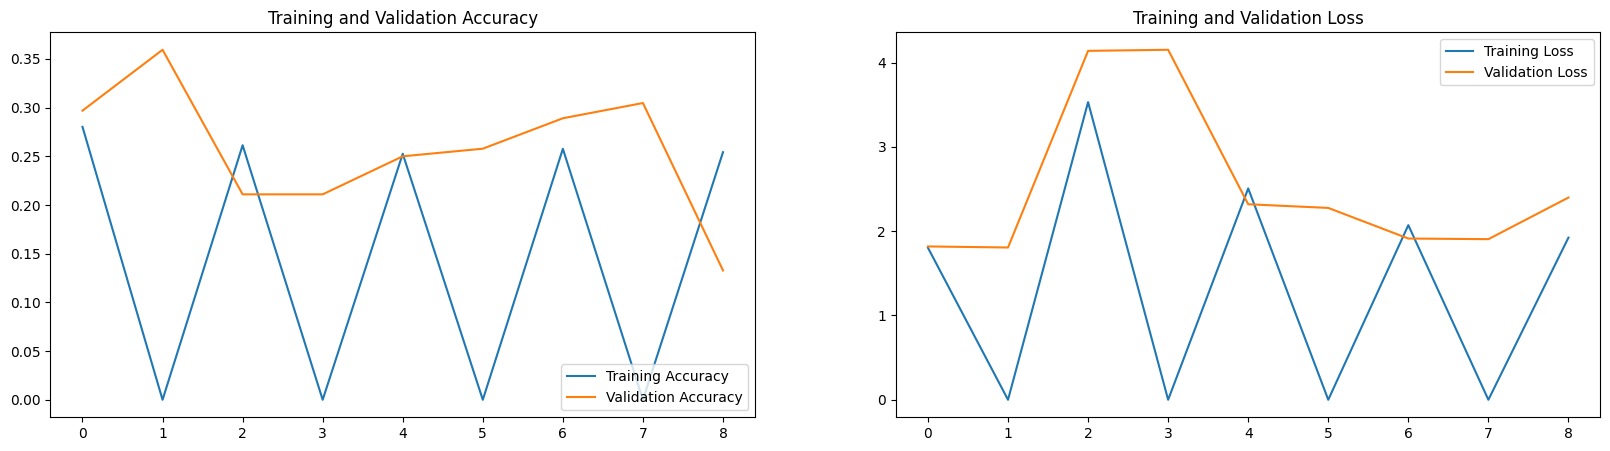

In [51]:
plot_training_history(history)

# Model Evaluation

In [52]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.3188 - loss: 1.7826
  4/113 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.3320 - loss: 1.7066

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.3241 - loss: 1.7791
final train accuracy = 32.11 , validation accuracy = 32.39


# Plotting Confusion Matrix

# Making Predictions

# Model 2: Image Augmentation

In [60]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


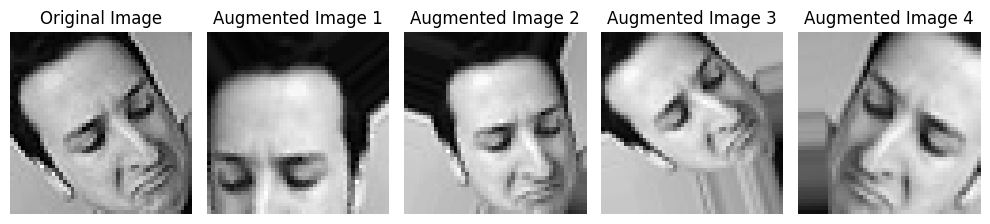

In [67]:
# Path to your specific image
image_path = '/content/train/disgust/Training_10371709.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to
#(1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch
    # save image
    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

# Iterates over the remaining subplots (axes.flat[1:]) and generates augmented images using data_generator.
# data_generator.flow(img_array, batch_size=1): Generates a batch of augmented images.
# next(aug_iter)[0]: Retrieves the first augmented image from the batch.
# Each augmented image is displayed in its respective subplot.


plt.tight_layout()
plt.show()

In [66]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training_log.keras'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = len(validation_generator) // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2041 - loss: 13.4200
Epoch 1: val_loss improved from inf to 12.13916, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.2042 - loss: 13.4174 - val_accuracy: 0.1719 - val_loss: 12.1392 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_loss did not improve from 12.13916
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1641 - val_loss: 12.2559 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2331 - loss: 10.7903
Epoch 3: val_loss improved from 12.13916 to 9.58182, saving model to /content/FER_2013_Emotion_Dection/Custom_CNN_from_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.2331 - loss: 10.7888 - val_accuracy: 0.2344 - val_loss: 9.5818 - learning

Check it's predcition and accuracy.   plot confusion matrix and grapph for acc nd val acc

**# Model 3: Tranfer Learning VGGNET**

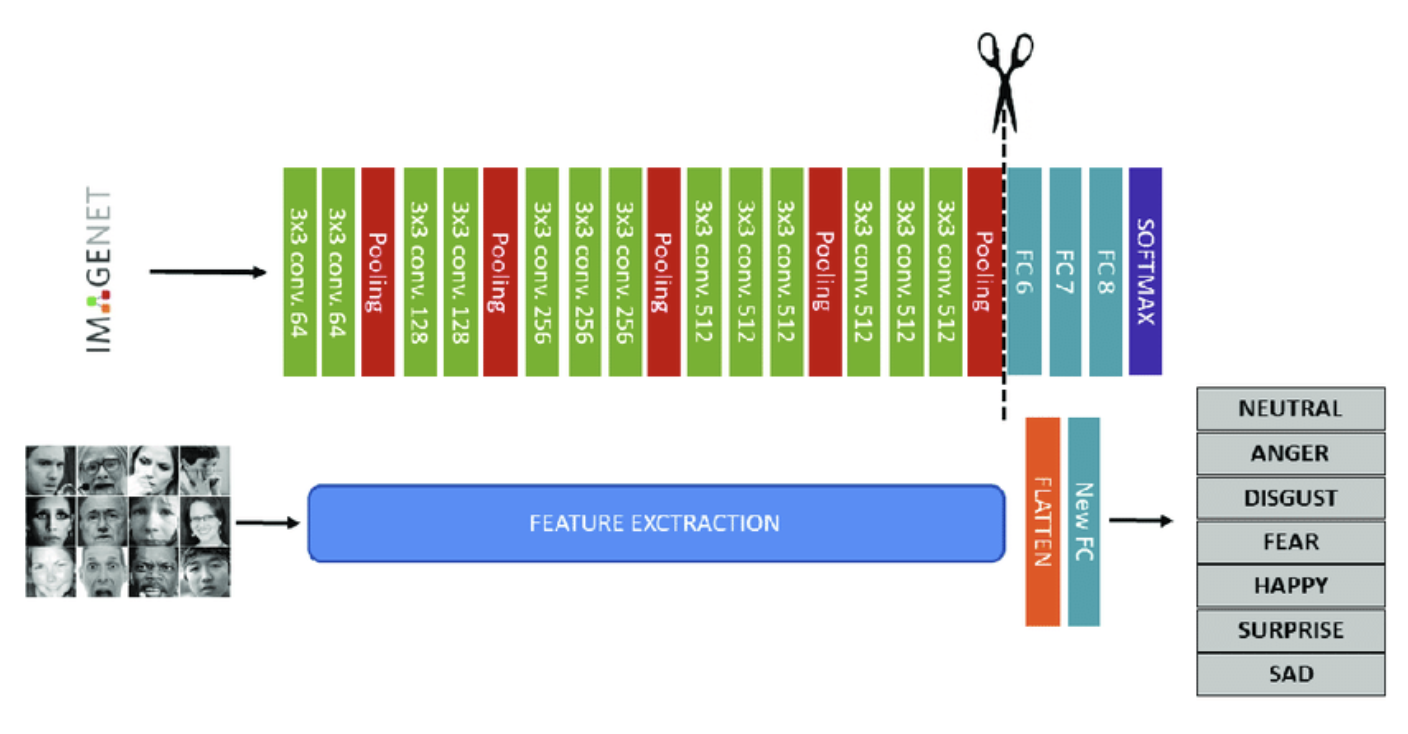

In [27]:

# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1/255.,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.1,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.1,  # Range (as a fraction of total height) for random vertical shifts
    # shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    # validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_preprocessor = ImageDataGenerator(rescale=1/255.)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
    )

Found 28709 images belonging to 7 classes.
Found 0 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [28]:
# extract class labels for all instances in the training dataset

classes = np.array(train_generator.classes)

#calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjust weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),  # unique class labels
    y = classes # class labels for each instances

)


# create a dict to map class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

#output the class weights
print(class_weights_dict)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [29]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [30]:
classes = 7

#clear the previous Tenserflow sessions
tf.keras.backend.clear_session()

#load the VGG16 base model, excluding its top(fully connected) layers
vgg = VGG16(input_shape=(224,224,3), include_top=False,weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# make the specifiesd layers non-trainable
for layer in vgg.layers[:-3]:
  layer.trainable = False


vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [37]:
#flattening the layer and adding custom dense layers
x = Flatten()(vgg.output)

#adding FC layers with relu and he normal
x= Dense(1024,activation='relu', kernel_initializer='he_normal')(x)
x=Dropout(0.5)(x)

x=Dense(512,activation='relu', kernel_initializer='he_normal')(x)
x=Dropout(0.5)(x)

#op layer using softmax actiation
output = Dense(7,activation='softmax',kernel_initializer='he_normal')(x)


#creating model
model=Model(inputs=vgg.input, outputs=output)




In [46]:

#compiling model
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1 = 0.9,beta_2=0.999,amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [42]:
cnn_path='/content/FER_2013_Emotion_Dection/VGGnet16_Transfer_learning'
name='VGG_transfer_learning.keras'
chk_path = os.path.join(cnn_path,name)

In [47]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training_log.keras'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = len(validation_generator) // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1


In [ ]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=test_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks,
    class_weight=class_weights_dict)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 41/449 ━━━━━━━━━━━━━━━━━━━━ 5:49 857ms/step - accuracy: 0.1426 - loss: 2.3113